# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [3]:
# import libraries
import pandas as pd
import sqlite3
import re
import time
import numpy as np
import warnings
import pickle
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

warnings.simplefilter('ignore')


from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sqlalchemy import create_engine

from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score, classification_report,make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from scipy.stats import hmean
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vitaliy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vitaliy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vitaliy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vitaliy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# load data from database
engine = create_engine('sqlite:///twitter_messages.db')
df = pd.read_sql('SELECT * FROM message',engine)

X = df['message']
y = df.iloc[:,4:40]

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    '''
    Function that transfers text to tokes
    Input: text as string, a unmodified plain text
    Output: tokens created from modified and cleaned text
    '''
    
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")

    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

First classifier that I am going to test is RandomForest (in combination with Count Vectorizer and Tfidf). 

In [17]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

Here I have three evaluation functions:
1. **"calculate_metrics"** - creates a table with f1, precision and recall values for each category
2. **"median_f1"** - function that calculates f1 score for each category and returns a median from all scores
3. **"f1_micro_average"** - function that calculates a s.c. micro average f1 (taken from [here](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin))

In [11]:
def calculate_metrics(y_test, y_pred):
    '''
    Calculates precision, recall and f1 metrics for each category and combines it into a single dataframe
    Input: y_test, y_pred - arrays with test and prediction values
    Output: res_metrics - a pandas dataframe with all metric values for each category
    '''
    
    res_metrics = []
    for i in range(y_pred.shape[1]):
        f1 = f1_score(y_test[:,i],y_pred[:,i])
        precision = precision_score(y_test[:,i],y_pred[:,i])
        recall = recall_score(y_test[:,i],y_pred[:,i])
        res_metrics.append([f1,precision,recall])
    return res_metrics

def median_f1(y_test,y_pred):
    '''
    Calculates f1 metrics for each category and claculates a median from these values
    Input: y_test, y_pred - arrays with test and prediction values
    Output: median of f1 metrics of all categories
    '''
    
    f1 = []
    for i in range(y_pred.shape[1]):
        f1.append(f1_score(np.array(y_test)[:,i],y_pred[:,i]))
    return np.median(f1)

def f1_micro_average(y_test,y_pred):
    '''
    Calculates s.c. micro average f1
    Input: y_test, y_pred - arrays with test and prediction values
    Output: micro average f1
    '''
    
    TN = []
    FP = []
    FN = []
    for i in range(y_pred.shape[1]):
        TN.append(confusion_matrix(np.array(y_test)[:,i],y_pred[:,i])[1,1])
        FP.append(confusion_matrix(np.array(y_test)[:,i],y_pred[:,i])[1,0])
        FN.append(confusion_matrix(np.array(y_test)[:,i],y_pred[:,i])[0,1])
    precision = np.sum(TN) / (np.sum(TN) + np.sum(FN))
    recall = np.sum(TN) / (np.sum(TN) + np.sum(FP))
    
    return hmean([precision,recall])

### 4. Train/Test splits

A "normal" train/test split with test set size of 20%

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, test_size = 0.2)

### 5. Train and Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

First shot using pipeline with a RandomForest classifier showed a result that can not be considered as very good. The median f1 score lies at 0.14 which means that there are many categories that were poorly predicted. However, a quick look into the badly predicted categories reveals categories that are strongly skewed (for example "offer", "missing people"). But there is a definately room to improve this model. 

In [18]:
start = time.time()
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
print('F1_Median: {}'.format(median_f1(y_test,y_pred)))
print('F1_micro_average: {}'.format(f1_micro_average(y_test,y_pred)))
print('Time required: {}'.format(time.time()-start))

F1_Median: 0.14492753623188404
F1_micro_average: 0.6152200488997556
Time required: 226.63196277618408


In [19]:
test_res = calculate_metrics(y_test.values,y_pred)
print('Result on Test Data using untuned MultiOutputClassifier with Random Forest')
print(pd.DataFrame(test_res, columns = ['f1','precision','recall'], index = df.iloc[:,4:40].columns ) )

Result on Test Data using untuned MultiOutputClassifier with Random Forest
                              f1  precision    recall
related                 0.882367   0.844965  0.923234
request                 0.552764   0.822650  0.416216
offer                   0.000000   0.000000  0.000000
aid_related             0.663012   0.761848  0.586876
medical_help            0.155844   0.642857  0.088670
medical_products        0.144928   0.645161  0.081633
search_and_rescue       0.179775   0.695652  0.103226
security                0.021739   0.250000  0.011364
military                0.131313   0.500000  0.075581
water                   0.563636   0.807292  0.432961
food                    0.692607   0.822171  0.598319
shelter                 0.477237   0.821622  0.336283
clothing                0.209524   0.785714  0.120879
money                   0.055556   0.750000  0.028846
missing_people          0.000000   0.000000  0.000000
refugees                0.093458   0.714286  0.050000
death  

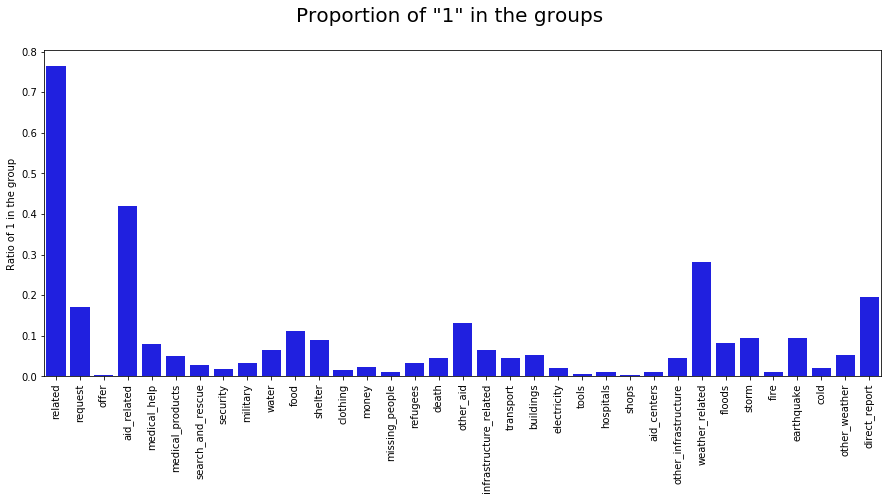

In [68]:
ratio_one = []
for i in y.columns:
    ratio_one.append(y[i].sum() / y.shape[0])

skew_data = pd.DataFrame({
    'group':y.columns,
    'ratio_one':ratio_one
})
fig, axes = plt.subplots(figsize = (15,6))
sns.barplot(x= 'group', y = 'ratio_one', data = skew_data, color = 'blue', ax = axes)
plt.ylabel('Ratio of 1 in the group')
plt.xlabel('')
plt.xticks(rotation = 90)
fig.suptitle('Proportion of "1" in the groups', fontsize  = 20); 

### 6. Improve your model

To improve the model I've implemented Grid Search procedure. As result of 36 combination with cv = 2. I came to the set of hyperparameters which significantly improves the performance of RandomForest based pipeline. However strongly skewed groups still remain poorly predictable.

In [24]:
# Create grid search object

parameters = {'vect__min_df': [1, 5],
              'clf__estimator__n_estimators': [10, 50],
             'clf__estimator__min_samples_split':[2,50,500],
             'clf__estimator__max_depth':[None,5,10]}

scorer = make_scorer(f1_micro_average)

cv = GridSearchCV(pipeline, param_grid = parameters, scoring = scorer, verbose = 10, cv = 2)

tuned_model_rf = cv.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__min_df=1 
[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__min_df=1, score=0.59943273751737, total= 1.5min
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__min_df=1, score=0.5898971288192845, total= 1.5min
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__min_df=5, score=0.6229568955931952, total= 1.1min
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.1min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, vect__min_df=5, score=0.6167781857491659, total= 1.1min
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.5min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, vect__min_df=1, score=0.6278083854701653, total= 5.6min
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.8min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, vect__min_df=1, score=0.6325805257312106, total= 5.5min
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 19.1min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, vect__min_df=5, score=0.6482635796972396, total= 3.4min
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 23.2min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, vect__min_df=5, score=0.6487622014161792, total= 3.5min
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=10, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 27.3min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=10, vect__min_df=1, score=0.6248326701263456, total=  57.2s
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=10, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 28.6min remaining:    0.0s


[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=10, vect__min_df=1, score=0.6190028915041347, total=  57.3s
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=10, vect__min_df=5 
[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=10, vect__min_df=5, score=0.6416186009738918, total=  52.2s
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=10, vect__min_df=5 
[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=10, vect__min_df=5, score=0.639580791041562, total=  51.0s
[CV] clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=50, vect__min_df=1 
[CV]  clf__estimator__max_depth=None, clf__estimator__min_samples_split=50, clf__estimator__n_estimators=50, vect__min_df=1, score=0.6

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 109.4min finished


The resulting set of parameters:

In [26]:
tuned_model_rf.best_params_

{'clf__estimator__max_depth': None,
 'clf__estimator__min_samples_split': 50,
 'clf__estimator__n_estimators': 50,
 'vect__min_df': 5}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [28]:
print('F1_Median: {}'.format(median_f1(y_test,y_pred)))
print('F1_micro_average: {}'.format(f1_micro_average(y_test,y_pred)))

F1_Median: 0.18309859154929575
F1_micro_average: 0.6686651256862177


In [27]:
y_pred = tuned_model_rf.predict(X_test)
test_res = calculate_metrics(y_test.values,y_pred)
print('Result on Test Data using tuned MultiOutputClassifier with Random Forest')
print(pd.DataFrame(test_res, columns = ['f1','precision','recall'], index = df.iloc[:,4:40].columns ) )

Result on Test Data using tuned MultiOutputClassifier with Random Forest
                              f1  precision    recall
related                 0.891412   0.844200  0.944217
request                 0.623218   0.837591  0.496216
offer                   0.000000   0.000000  0.000000
aid_related             0.728508   0.738717  0.718577
medical_help            0.200820   0.597561  0.120690
medical_products        0.183099   0.666667  0.106122
search_and_rescue       0.072289   0.545455  0.038710
security                0.000000   0.000000  0.000000
military                0.196078   0.625000  0.116279
water                   0.642612   0.834821  0.522346
food                    0.750903   0.810916  0.699160
shelter                 0.593620   0.795539  0.473451
clothing                0.178218   0.900000  0.098901
money                   0.019048   1.000000  0.009615
missing_people          0.000000   0.000000  0.000000
refugees                0.143498   0.695652  0.080000
death    

### 8. Try improving your model further. 

In order to even further improve the model I've substituted RandomForest classifier with AdaBoost. As a result, I got dramatic increase in "f1-median" metric. This means that AdaBoost is able to acurately predict more groups as Random Forest. Even some strongly skewed groups like "missing people" were somewhat accurate predicted by AdaBoost. However, the "micro average f1" remained almost the same as by Random Forest. Important to notice that Adaboost based pipeline with 50 estimators required almost the same time for a fit as Random Forest. Adaboost with 100 estimators wasn't significantly better as a model with 50 estimators although needed apprx 2 times longer to fit a train data.

**As a result a AdaBoost based pipeline with 50 estimators is chosen as a final model**

In [32]:
pipeline_2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])

start = time.time()
pipeline_2.fit(X_train,y_train)
y_pred = pipeline_2.predict(X_test)
print('F1_Median: {}'.format(median_f1(y_test,y_pred)))
print('F1_micro_average: {}'.format(f1_micro_average(y_test,y_pred)))
print('Time required: {}'.format(time.time()-start))

F1_Median: 0.39893617021276595
F1_micro_average: 0.6665281816922863
Time required: 246.40709376335144


In [33]:
pipeline_3 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier(n_estimators=100)))
])

start = time.time()
pipeline_3.fit(X_train,y_train)
y_pred = pipeline_3.predict(X_test)
print('F1_Median: {}'.format(median_f1(y_test,y_pred)))
print('F1_micro_average: {}'.format(f1_micro_average(y_test,y_pred)))
print('Time required: {}'.format(time.time()-start))

F1_Median: 0.3771043771043771
F1_micro_average: 0.6715018816284639
Time required: 465.507625579834


In [70]:
y_pred = pipeline_3.predict(X_test)
test_res = calculate_metrics(y_test.values,y_pred)
print('Result on Test Data using tuned MultiOutputClassifier with AdaBoost')
print(pd.DataFrame(test_res, columns = ['f1','precision','recall'], index = df.iloc[:,4:40].columns ) )

Result on Test Data using tuned MultiOutputClassifier with AdaBoost
                              f1  precision    recall
related                 0.876047   0.802856  0.963920
request                 0.635324   0.770416  0.540541
offer                   0.000000   0.000000  0.000000
aid_related             0.703899   0.772501  0.646488
medical_help            0.377104   0.595745  0.275862
medical_products        0.442708   0.611511  0.346939
search_and_rescue       0.260465   0.466667  0.180645
security                0.086207   0.178571  0.056818
military                0.368794   0.472727  0.302326
water                   0.696793   0.728659  0.667598
food                    0.746161   0.806641  0.694118
shelter                 0.602067   0.723602  0.515487
clothing                0.573248   0.681818  0.494505
money                   0.313253   0.419355  0.250000
missing_people          0.225806   0.437500  0.152174
refugees                0.359322   0.557895  0.265000
death         

### 9. Export your model as a pickle file

In [71]:
pickle.dump(pipeline_2, open('model.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.